In [1]:
base_path = '/mnt/ceph/users/apricewhelan/projects/dr2-lmc-cluster/'

In [2]:
import sys
from os import path
import glob

from astropy.table import Table, hstack
import astropy.units as u
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
from scipy.special import logsumexp
from scipy.stats import truncnorm
import emcee
import corner

from isochrones import StarModel

_path = path.abspath(path.join(base_path, 'scripts'))
if _path not in sys.path:
    sys.path.append(_path)
from run_isochrones_sample import load_data

In [4]:
idx = []

model_files = glob.glob(path.join(base_path, 'cache/starmodels-*.hdf5'))
nstars = len(model_files)
nsamples = 2048

all_samples = Table()
for name in ['age', 'distance', 
             'mass1', 'mass2a', 'mass2b', 
             'radius', 'feh', 'AV']:
    all_samples[name] = np.zeros((nstars, nsamples))

for i, filename in enumerate(model_files):
    index = int(path.basename(filename)[3:].split('-')[1].split('.')[0])
    idx.append(index)
    
    model = StarModel.load_hdf(filename)
    m2a = model.samples['mass_0_1'].copy()
    m2b = model.samples['mass_0_2'].copy()
    
    swap_mask = m2b > m2a
    model.samples['mass_0_1'][swap_mask] = m2b[swap_mask]
    model.samples['mass_0_2'][swap_mask] = m2a[swap_mask]
    
    choice = np.random.choice(len(model.samples), size=2048, replace=False)
    
    for name in ['age', 'radius']:
        all_samples[name][i] = model.samples[name+'_0_0'][choice]
        
    all_samples['mass1'][i] = model.samples['mass_0_0'][choice]
    all_samples['mass2a'][i] = model.samples['mass_0_1'][choice]
    all_samples['mass2b'][i] = model.samples['mass_0_2'][choice]
    
    for name in ['distance', 'feh', 'AV']:
        all_samples[name][i] = model.samples[name+'_0'][choice]
    
all_idx = np.array(idx)
all_samples = np.array(all_samples)

In [5]:
decam = load_data(path.join(base_path, 'data/decam_apw.fits'))
decam = decam[np.isin(decam['index'], all_idx)]
col = decam['GMAG'] - decam['IMAG']
mag = decam['GMAG']

# mask = (col < -0.) & (mag < 21)
mask = (col < 0.3) & (mag < 22)
decam = decam[mask]
col = col[mask]
mag = mag[mask]

In [6]:
samples_mask = np.isin(all_idx, decam['index'])

samples = all_samples[samples_mask]
idx = all_idx[samples_mask]

samples = samples[np.argsort(idx)]
idx = idx[np.argsort(idx)]

assert np.all(idx == decam['index'])

(22, 15)

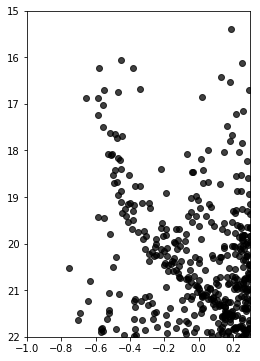

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))
ax.plot(col, mag, marker='o', color='k', alpha=0.75, ls='none')
ax.set_xlim(-1, 0.3)
ax.set_ylim(22, 15)

(22, 15)

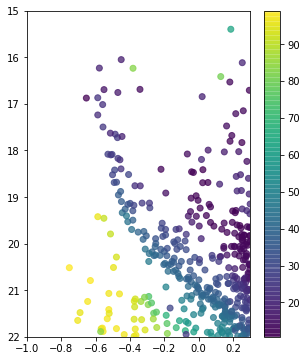

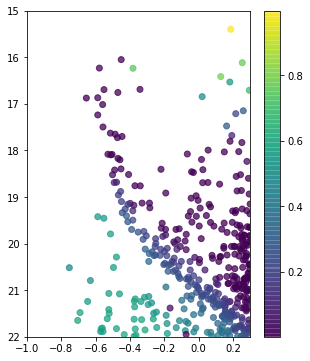

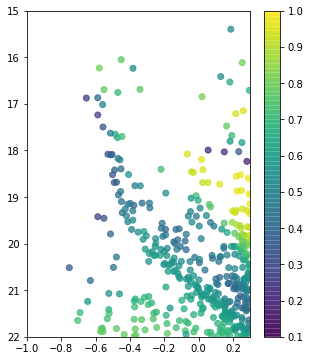

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 6))
cs = ax.scatter(col, mag, c=np.median(samples['distance'], axis=-1) / 1000, 
                marker='o', alpha=0.75)
fig.colorbar(cs)
ax.set_xlim(-1, 0.3)
ax.set_ylim(22, 15)

# ---

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
cs = ax.scatter(col, mag, c=np.median(samples['AV'], axis=-1), 
                marker='o', alpha=0.75)
fig.colorbar(cs)
ax.set_xlim(-1, 0.3)
ax.set_ylim(22, 15)

# ---

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
cs = ax.scatter(col, mag, c=np.mean(samples['mass2b'] / samples['mass2a'], axis=-1), 
                vmin=1e-1, vmax=1e0,
                marker='o', alpha=0.75)
fig.colorbar(cs)
ax.set_xlim(-1, 0.3)
ax.set_ylim(22, 15)

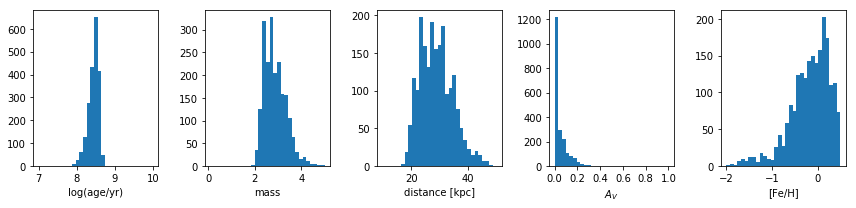

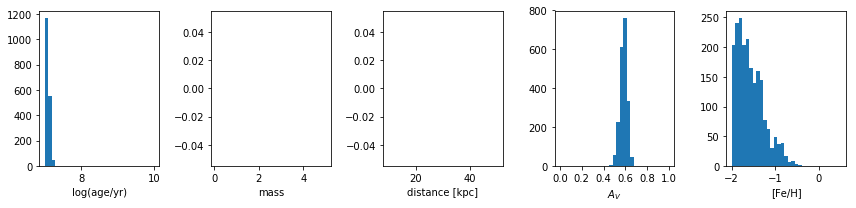

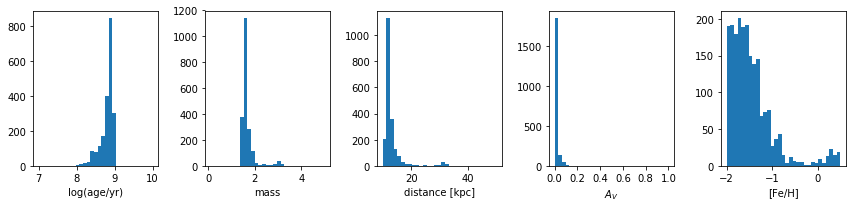

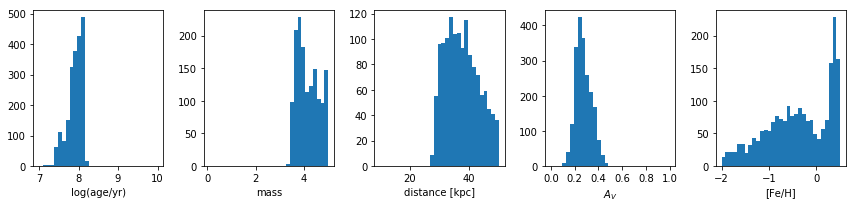

In [12]:
for i in range(4):
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))

    ax = axes[0]
    ax.hist(samples['age'][i], bins=np.linspace(7, 10, 32));
    ax.set_xlabel('log(age/yr)')
    
    ax = axes[1]
    ax.hist(samples['mass1'][i], bins=np.linspace(0.1, 5, 32));
    ax.set_xlabel('mass')
    
    ax = axes[2]
    ax.hist(samples['distance'][i] / 1000., bins=np.linspace(10, 50, 32));
    ax.set_xlabel('distance [kpc]')
    
    ax = axes[3]
    ax.hist(samples['AV'][i], bins=np.linspace(0, 1, 32));
    ax.set_xlabel('$A_V$')
    ax.set_xticks(np.arange(0, 1+1e-3, 0.2))
    
    ax = axes[4]
    ax.hist(samples['feh'][i], bins=np.linspace(-2, 0.5, 32));
    ax.set_xlabel('[Fe/H]')
    
    fig.tight_layout()

---

In [13]:
from scipy.stats import truncnorm
from scipy.special import logsumexp

from schwimmbad import MultiPool

In [14]:
age_ab = (5., 10.3)
dist_ab = (1000., 100000)

# def old_ln_prior(x):
#     """ Uniform in log(age/yr) between 5, 10.3 """
#     x = np.array(x)
#     null_mask = (x < age_ab[0]) | (x > age_ab[1])
#     lnp = np.zeros_like(x)
    
#     lnp[null_mask] = -np.inf
#     lnp[~null_mask] = -np.log(age_ab[1] - age_ab[0])
#     return lnp

def old_ln_prior(x):
    x = np.array(x)
    null_mask = (x < age_ab[0]) | (x > age_ab[1])
    lnp = np.zeros_like(x)
    
    lnp[null_mask] = -np.inf
    lnp[~null_mask] = np.log(model._priors['age'].pdf(x[~null_mask]))
    return lnp

def ln_truncnorm(x, mu, sigma, clip_a, clip_b):
    a, b = (clip_a - mu) / sigma, (clip_b - mu) / sigma
    return truncnorm.logpdf(x, a, b, loc=mu, scale=sigma)

def ln_distance_unif_dens(x, a, b):
    x = np.array(x)
    null_mask = (x < a) | (x > b)
    
    lnp = np.zeros_like(x)
    
    lnp[null_mask] = -np.inf
    lnp[~null_mask] = np.log(model._priors['distance'].pdf(x[~null_mask]))
    
    return lnp

def ln_normal(x, mu, var):
    return -0.5*np.log(2*np.pi) - 0.5*np.log(var) - 0.5 * (x-mu)**2 / var

def ln_likelihood(p, samples):
    # f, dist_mu_fg = p
    # f, age_mu_fg, dist_mu_fg = p
    f, age_mu_fg, dist_mu_fg, feh_mu_fg, av_mu_fg = p
    
    age_mu_bg = 9.8
    # age_mu_fg = 8.2
    # sigma_bg = np.exp(lnsigma_bg)
    age_sigma_bg = 1.
    age_sigma_fg = 0.04
    
    # dist_mu_fg = 10.3 # ln(30000)
    # dist_sigma_fg = 0.1 # small
    # dist_mu_fg = 30000.
    dist_mu_fg = dist_mu_fg * 1000 # kpc to pc
    dist_sigma_fg = 0.25 * 1000 # kpc to pc
    
    feh_sigma_fg = 0.01
    
    # av_mu_fg = 0.25
    av_sigma_fg = 0.01
    
    lp = -np.log(age_ab[1] - age_ab[0])
    l1_age = logsumexp(ln_truncnorm(samples['age'], 
                                    age_mu_fg, age_sigma_fg, *age_ab) - lp, axis=-1) + np.log(f)
    l2_age = logsumexp(ln_truncnorm(samples['age'], 
                                    age_mu_bg, age_sigma_bg, *age_ab) - lp, axis=-1) + np.log(1-f)
    ll_age = np.logaddexp(l1_age, l2_age)
    
    # ---
    
    # lp = -np.log(np.log(dist_ab[1]) - np.log(dist_ab[0])) # uniform space density
    lp = ln_distance_unif_dens(samples['distance'], *dist_ab)
    l1_dist = logsumexp(ln_truncnorm(samples['distance'], 
                                     dist_mu_fg, dist_sigma_fg, *dist_ab) - lp, axis=-1) + np.log(f)
    l2_dist = logsumexp(lp, axis=-1) + np.log(1-f)
    ll_dist = np.logaddexp(l1_dist, l2_dist)
    
    # ---
    
    lp = np.log(model._priors['feh'].pdf(samples['feh']))
    l1_feh = logsumexp(ln_normal(samples['feh'], feh_mu_fg, feh_sigma_fg) - lp, axis=-1) + np.log(f)
    l2_feh = logsumexp(lp, axis=-1) + np.log(1-f)
    ll_feh = np.logaddexp(l1_feh, l2_feh)
    
    # ---
    
    lp = np.log(model._priors['AV'].pdf(samples['AV']))
    l1_AV = logsumexp(ln_normal(samples['AV'], av_mu_fg, av_sigma_fg) - lp, axis=-1) + np.log(f)
    l2_AV = logsumexp(lp, axis=-1) + np.log(1-f)
    ll_AV = np.logaddexp(l1_AV, l2_AV)
    
    return (ll_age + ll_dist + ll_feh + ll_AV, 
            (l1_age+l1_dist+l1_feh+l1_AV, l2_age+l2_dist+l2_feh+l2_AV))

def ln_prior(p):
    f, age_mu_fg, dist_mu_fg, feh_mu_fg, av_mu_fg = p
    
    lp = 0.
    
    if not 0 < f < 1:
        return -np.inf
    lp += np.log(1.)
    
    if not 6 < age_mu_fg < 9:
        return -np.inf
    lp += np.log(9 - 6.)
    
    if not 10 < dist_mu_fg < 60:
        return -np.inf
    lp += np.log(60 - 10)
    
    if not -2 < feh_mu_fg < 0:
        return -np.inf
    lp += np.log(0 - -2)
    
    if not 0.001 < av_mu_fg < 1:
        return -np.inf
    lp += np.log(1 - 0.001)
    
    return lp

def ln_posterior(p, *args):
    lnp = ln_prior(p)
    # if not np.isfinite(lnp):
    #     return -np.inf, None

    lnl, blobs = ln_likelihood(p, *args)
    lnl = lnl.sum()
    if not np.isfinite(lnl) or not np.isfinite(lnp):
        return -np.inf, blobs

    return lnp + lnl, blobs

In [17]:
ln_posterior([0.8, 8., 30., -1, 0.1], samples)[0]

232 ms ± 3.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
res = minimize(lambda *args, **kwargs: -ln_posterior(*args, **kwargs)[0], 
               x0=[0.8, 8.2, 30, -1.2, 0.1], method='powell', args=(samples, ))

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in log
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in log
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in log
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in log
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in log
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in log
/mnt/home/apricewhelan/anaconda3/lib/python3.7/s

In [19]:
res

   direc: array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])
     fun: -12411.913200954667
 message: 'Optimization terminated successfully.'
    nfev: 130
     nit: 2
  status: 0
 success: True
       x: array([ 0.79222834,  8.11901066, 29.9139701 , -1.09821059,  0.16239074])

In [20]:
p0 = res.x
nwalkers = 64

ndim = len(p0)
p0 = np.random.normal(p0, [0.02, 0.02, 0.02, 0.01, 0.01], size=(nwalkers, ndim))

In [ ]:
with MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, 
                                    args=(samples, ), pool=pool)

    pos, *_ = sampler.run_mcmc(p0, 128)
    print('done burning in')
    sampler.reset()
    _ = sampler.run_mcmc(pos, 256)

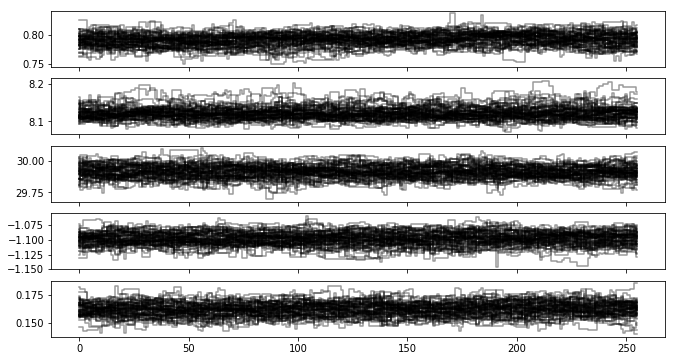

In [22]:
fig, axes = plt.subplots(ndim, 1, figsize=(11, 6), sharex=True, sharey='row')
for k in range(sampler.chain.shape[-1]):
    for walker in sampler.chain[..., k]:
        axes[k].plot(walker, drawstyle='steps-mid', 
                     marker='', alpha=0.4, color='k')

In [61]:
np.save(path.join(base_path, 'output/hierarch_chain.npy'), sampler.chain)
np.save(path.join(base_path, 'output/hierarch_blobs.npy'), np.array(sampler.blobs))

In [25]:
norm = 0.0
post_prob = np.zeros(blob.shape[-1])
for i in range(sampler.chain.shape[1]):
    for j in range(sampler.chain.shape[0]):
        ll_fg, ll_bg = blob[i][j]
        post_prob += np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
        norm += 1
post_prob /= norm

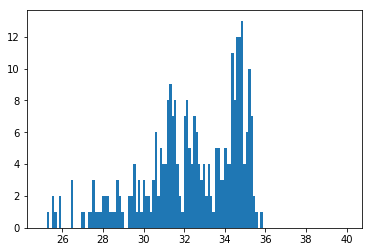

In [37]:
plt.hist(np.logaddexp(ll_fg, ll_bg), bins=np.linspace(25, 40, 128));

In [42]:
failed = np.logaddexp(ll_fg, ll_bg) < 32
failed.sum()

245

(22, 15)

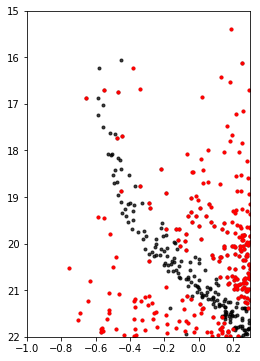

In [43]:
thresh = 0.9

fig, ax = plt.subplots(1, 1, figsize=(4, 6))
ax.plot(col[post_prob > thresh], mag[post_prob > thresh], 
        marker='.', color='k', alpha=0.75, ls='none')
ax.plot(col[post_prob < thresh], mag[post_prob < thresh], 
        marker='.', color='#666666', alpha=0.5, ls='none')

ax.plot(col[failed], mag[failed], 
        marker='.', color='r', alpha=1, ls='none')

# _mask = (post_prob > thresh) & (col > -0.1) & (mag < 19.7)
_mask = (post_prob > thresh) & (col > -0.25) & (col < -0.2) & (mag < 19.8) & (mag > 19.5)
# ax.plot(col[_mask], mag[_mask], 
#         marker='o', color='r', alpha=0.5, ls='none')

ax.set_xlim(-1, 0.3)
ax.set_ylim(22, 15)

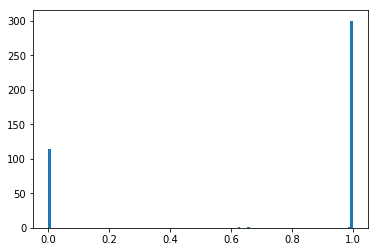

In [44]:
plt.hist(post_prob, bins=np.linspace(0, 1, 128));

(22, 15)

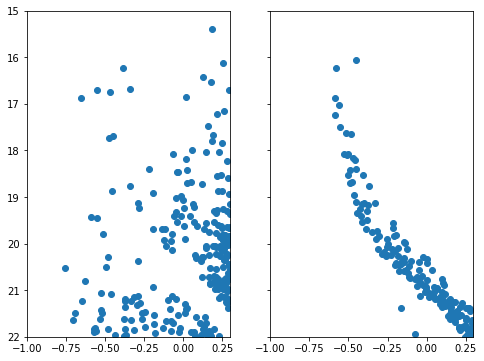

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6),
                         sharex=True, sharey=True)

ax = axes[0]
ax.scatter(col[failed | (post_prob < 0.5)], 
           mag[failed | (post_prob < 0.5)],
           marker='o')

ax = axes[1]
ax.scatter(col[~(failed | (post_prob < 0.5))], 
           mag[~(failed | (post_prob < 0.5))],
           marker='o')

ax.set_xlim(-1, 0.3)
ax.set_ylim(22, 15)

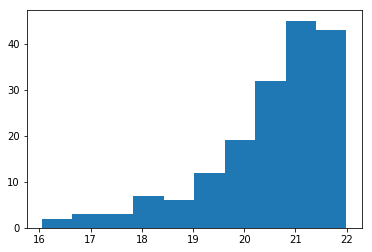

In [46]:
plt.hist(mag[~(failed | (post_prob < 0.5))], 
         weights=post_prob[~(failed | (post_prob < 0.5))]);

In [55]:
decam_tbl = decam.copy()

keep_cols = ['GMAG', 'IMAG', 'GERR', 'IERR', 'RA', 'DEC', 'index']
new_names = dict(zip(keep_cols, ['g', 'i', 'g_err', 'i_err', 'ra', 'dec']))

for name in decam_tbl.colnames:
    if name not in keep_cols:
        decam_tbl.remove_column(name)
    
    elif name in new_names:
        decam_tbl.rename_column(name, new_names[name])

In [58]:
decam_tbl['membership_prob'] = post_prob
decam_tbl['membership_prob'][failed] = np.nan

In [60]:
decam_tbl.write(path.join(base_path, 'output/decam_membership.fits'))